In [1]:
print(1)

1


In [2]:
import sys
from pathlib import Path
from typing import List
%config Completer.use_jedi = False # fix autocomplete nor working

project_dir = Path('/home/al.thomas/sync/development/data2text/')
sys.path.insert(0, str(project_dir))
from hdfs_utils import copy_from_hdfs_to_local, copy_from_local_to_hdfs

def copy_artifacts(run_id: str, source_dir: str, model_checkpoints: List[str], source_files: List[str]):
    """
    run_id: mlflow run id
    source_dir: name of the directory containing source files in mlflow artifacts directory (on hdfs)
    model_checkpoints: file names of the checkpoints to load
    source_files: files useful in this notebook (source files, config, etc)
    """
    
    # copy mlflow model checkpoints to local
    artifact_path = f'viewfs:///user/al.thomas/mlflow_artifacts/{run_id}/artifacts'
    checkpoints = []
    for m in model_checkpoints:
        checkpoints += copy_from_hdfs_to_local(f'{artifact_path}/{m}', str(project_dir / f'models/{run_id}'))
    print('Copied checkpoints:\n' + '\n'.join(checkpoints))

    # copy source code used to train model to local
    copied_files = []
    for f in source_files:
        copied_files += copy_from_hdfs_to_local(artifact_path + f'/{source_dir}/{f}', str(project_dir / f'models/{run_id}/artifact_code'))
    print('Copied source files:\n' + '\n'.join(copied_files))

def get_relations_as_plain_text(ex):
    """
    ex: one sample of batch_raw, containing raw relations and entity text
    """
    # list of entities in the sentence as plain text
    ents = [[y for y in vocab["entity"](x) if y[0] != "<"] for x in ex["ent_text"]]
    
    # convert relations from indices (entity number, relation tokens) to text
    rel_text = [(ents[e1], vocab["relation"](r), ents[e2]) for e1, r, e2 in ex["raw_relation"]]
    rel_text = [f"{' '.join(e1)} -> {r} -> {' '.join(e2)}" for e1, r, e2 in rel_text]

    return rel_text

def get_pz_qz(model, batch):
    """
    model: g2t model
    batch: g2t batch, with graph, corresponding entities/relations, and target text
    
    return: (mu_p, log_sigma_p, mu_q, log_sigma_q), parameters of the conditional 
        prior and variational posterior
    """
    def len2mask(lens, device):
        max_len = max(lens)
        mask = torch.arange(max_len, device=device).unsqueeze(0).expand(len(lens), max_len)
        mask = mask >= torch.LongTensor(lens).to(mask).unsqueeze(1)
        return mask

    with torch.no_grad():
        device = batch["ent_text"].device
        # get the embedding of the graph g_root
        ent_mask = len2mask(batch["ent_len"], device)
        ent_text_mask = batch["ent_text"] == 0  # (sum(num_ent_i), max_ent_len)
        rel_mask = batch["rel"] == 0  # (bs, max_num_rel), 0 means the <PAD>
        g_ent, g_root, ent_enc = model.enc_forward(
            batch, ent_mask, ent_text_mask, batch["ent_len"], rel_mask
        )  # (bs, max_num_ent, d), except for g_root which is missing the 1st dim

        # get text embedding tar_inp, with entities (bs, max_sent_len, d)
        outs = []
        _mask = (batch["text"] >= len(model.text_vocab)).long()  # 0 if token is in vocab, 1 if entity or unknown
        _inp = (_mask * 3 + (1.0 - _mask) * batch["text"])  # 3 is <UNK>, otherwise use token index
        tar_inp = model.tar_emb(_inp.long())
        # embeddings for tokens in text vocab (0. if unknown or entity)
        embeddings_text = (1.0 - _mask[:, :, None]) * tar_inp  # (bs, max_sent_len, d)
        # embeddings for entity tokens (0. elsewhere)
        embeddings_ent = ent_enc[
            torch.arange(len(batch["text"]))[:, None].to(device),
            ((batch["text"] - len(model.text_vocab)) * _mask).long(),  # 0 for ENT_0 and other tokens, i for ENT_i
        ]  # (bs, max_sent_len, d)
        embeddings_ent = (embeddings_ent * _mask[:, :, None])  # set to 0. if not entity
        tar_inp = embeddings_text + embeddings_ent

        # get prior p(z|y)
        mu_p, log_sigma_p = model.get_vae_pz(g_root)
        std_p = torch.exp(0.5*log_sigma_p)  # log_sigma is actually log(sigma**2) in cycleGT code

        # get variational posterior q(z|x)
        mu_q, log_sigma_q = model.get_vae_qz(tar_inp)
        std_q = torch.exp(0.5*log_sigma_q)

    return mu_p, std_p, mu_q, std_q

# With original CycleGT code

In [3]:
run_id = '98491bf7557e4c93bdde85ceff3fb098'  # cold_unsup
g2t_checkpoint = 'g2t_model.pt_best_ep49'
artifact_dir = project_dir / f'models/{run_id}'
copy_artifacts(run_id,  source_dir='code', 
               model_checkpoints = [g2t_checkpoint],
               source_files=['g2t_model.py', 'main.py', 'data.py', 
                             'config.yaml', 'tmp_vocab.pt', 
                             'train.json', 'dev.json', 'test.json'])
# and add the source code to python path
sys.path.insert(0, str(project_dir / f'models/{run_id}'))

Copied checkpoints:
/home/al.thomas/sync/development/data2text/models/98491bf7557e4c93bdde85ceff3fb098/g2t_model.pt_best_ep49
Copied source files:
/home/al.thomas/sync/development/data2text/models/98491bf7557e4c93bdde85ceff3fb098/artifact_code/g2t_model.py
/home/al.thomas/sync/development/data2text/models/98491bf7557e4c93bdde85ceff3fb098/artifact_code/main.py
/home/al.thomas/sync/development/data2text/models/98491bf7557e4c93bdde85ceff3fb098/artifact_code/data.py
/home/al.thomas/sync/development/data2text/models/98491bf7557e4c93bdde85ceff3fb098/artifact_code/config.yaml
/home/al.thomas/sync/development/data2text/models/98491bf7557e4c93bdde85ceff3fb098/artifact_code/tmp_vocab.pt
/home/al.thomas/sync/development/data2text/models/98491bf7557e4c93bdde85ceff3fb098/artifact_code/train.json
/home/al.thomas/sync/development/data2text/models/98491bf7557e4c93bdde85ceff3fb098/artifact_code/dev.json
/home/al.thomas/sync/development/data2text/models/98491bf7557e4c93bdde85ceff3fb098/artifact_code/tes

In [4]:
from artifact_code.g2t_model import GraphWriter
from artifact_code.main import prep_data, write_txt, eval_g2t
from artifact_code.data import batch2tensor_g2t
from itertools import islice
import os
import shutil
import copy
import yaml
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn import decomposition
from tqdm import tqdm
from torch.distributions import Normal
from torch.utils.tensorboard import SummaryWriter

config = yaml.safe_load(open(artifact_dir/'artifact_code/config.yaml', "r"))
config["main"]["train_file"] = str(artifact_dir/'artifact_code/train.json')
config["main"]["dev_file"] = str(artifact_dir/'artifact_code/dev.json')
config["main"]["test_file"] = str(artifact_dir/'artifact_code/train.json')
dim_z = config["g2t"]["vae_dim"]

if os.path.isdir(project_dir / f"models/{run_id}/runs"):
    shutil.rmtree(project_dir / f"models/{run_id}/runs")
    writer = SummaryWriter(log_dir=project_dir / f"models/{run_id}/runs")

Using backend: pytorch
INFO:root:Start Logging
INFO:transformers.tokenization_utils:loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /home/al.thomas/.cache/torch/transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084


In [5]:
# load data
if os.path.isfile(project_dir / f'models/{run_id}/pool.pt'):
    print("Loading existing Pool objects...")
    pool = torch.load(project_dir / f'models/{run_id}/pool.pt')
    pool_unsup = torch.load(project_dir / f'models/{run_id}/pool_unsup.pt')
    vocab = torch.load(artifact_dir/'artifact_code/tmp_vocab.pt')["vocab"]
else:
    print("Creating Pool objects from vocab and data")
    config_pool = copy.deepcopy(config)
    config_pool["main"]["mode"] = "cold_unsup"
    pool_unsup, _ = prep_data(config_pool["main"], load=str(artifact_dir/'artifact_code/tmp_vocab.pt'))
    config_pool["main"]["mode"] = "sup"  # build the pool with all the info (text and graph for each example)
    pool, vocab = prep_data(config_pool["main"], load=str(artifact_dir/'artifact_code/tmp_vocab.pt'))

Loading existing Pool objects...


In [6]:
# load model
device = torch.device(0) if torch.cuda.is_available() else torch.device("cpu")
print(f"Device: {device}")

model = GraphWriter(copy.deepcopy(config["g2t"]), vocab)
model.to(device)
model.eval()
torch.no_grad()
model.load_state_dict(torch.load(artifact_dir/ g2t_checkpoint))

Device: cuda:0


<All keys matched successfully>

In [7]:
def get_pred(m, voc, batch, z):
    with torch.no_grad():
        pred = m(batch, beam_size=5, vae_z=z)
    pred = write_txt(batch, pred, voc["text"])
    return pred

def sample_predictions(batch, batch_raw):
    # input graph and text ground truth
    graph = [get_relations_as_plain_text(ex) for ex in batch_raw]
    target = write_txt(batch, batch["tgt"], vocab["text"])

    # predictions using prior
    pred_mu_p = get_pred(model, vocab, batch, p_z.loc)
    preds_p = []
    for z in p_z.sample((10,)):
        preds_p.append(get_pred(model, vocab, batch, z))

    # predicitons using posterior
    pred_mu_q = get_pred(model, vocab, batch, q_z.loc)
    preds_q = []
    for z in q_z.sample((10,)):
        preds_q.append(get_pred(model, vocab, batch, z))

    
    for i in range(len(target)):
        print(f"-----------\n{i}")
        print(f"Graph y:\n\t{graph[i]}")
        print(f"Target text x:\n\t{target[i]}")
        print(f"Predictions with z=mu_p: \n\t{pred_mu_p[i]}")
        print("Predictions with samples z~p(z|y) from prior:")
        for pred in preds_p:
            print(f"\t{pred[i]}")
        print(f"Predictions with z=mu_q: \n\t{pred_mu_q[i]}")
        print("Predictions with samples z~q(z|x) from posterior:")
        for pred in preds_q:
            print(f"\t{pred[i]}")

In [8]:
b = 0  # batch

batch_raw = next(islice(pool.draw_with_type(batch_size=16, shuffle=False, _type="train_g2t"), b, b+1))
batch = batch2tensor_g2t(batch_raw, device, vocab)

mu_p, std_p, mu_q, std_q = get_pz_qz(model, batch)
p_z = Normal(mu_p, std_p)
q_z = Normal(mu_q, std_q)

print(f"Sampling and converting predictions to text...")
sample_predictions(batch, batch_raw)

Sampling and converting predictions to text...
-----------
0
Graph y:
	["Aarhus Airport -> cityServed -> `` Aarhus , Denmark ''"]
Target text x:
	["the  Aarhus Airport  of  `` Aarhus , Denmark ''  ."]
Predictions with z=mu_p: 
	[" Aarhus Airport  serves the city of  `` Aarhus , Denmark ''  ."]
Predictions with samples z~p(z|y) from prior:
	[" Aarhus Airport  serves the city of  `` Aarhus , Denmark ''  ."]
	[" Aarhus Airport  serves the city of  `` Aarhus , Denmark ''  ."]
	[" Aarhus Airport  serves the city of  `` Aarhus , Denmark ''  ."]
	[" Aarhus Airport  serves the city of  `` Aarhus , Denmark ''  ."]
	[" Aarhus Airport  serves the city of  `` Aarhus , Denmark ''  ."]
	[" Aarhus Airport  serves the city of  `` Aarhus , Denmark ''  ."]
	[" Aarhus Airport  serves the city of  `` Aarhus , Denmark ''  ."]
	[" Aarhus Airport  serves the city of  `` Aarhus , Denmark ''  ."]
	[" Aarhus Airport  serves the city of  `` Aarhus , Denmark ''  ."]
	[" Aarhus Airport  serves the city of  `` Aarh

In [9]:
b = 0  # batch

batch_raw = next(islice(pool_unsup.draw_with_type(batch_size=16, shuffle=False, _type="train_g2t"), b, b+1))
batch = batch2tensor_g2t(batch_raw, device, vocab)
mu_p, std_p, mu_q, std_q = get_pz_qz(model, batch)
p_z = Normal(mu_p, std_p)
q_z = Normal(mu_q, std_q)

print(f"Sampling and converting predictions to text...")
sample_predictions(batch, batch_raw)

Sampling and converting predictions to text...
-----------
0
Graph y:
	[]
Target text x:
	["the  Aarhus Airport  of  `` Aarhus , Denmark ''  ."]
Predictions with z=mu_p: 
	[" `` Aarhus , Denmark ''  is the location of  Aarhus Airport  ."]
Predictions with samples z~p(z|y) from prior:
	[" Aarhus Airport  is located in  `` Aarhus , Denmark ''  ."]
	[" `` Aarhus , Denmark ''  is the location of  Aarhus Airport  ."]
	[" `` Aarhus , Denmark ''  is the location of  Aarhus Airport  ."]
	[" Aarhus Airport  is located in  `` Aarhus , Denmark ''  ."]
	["the location of  Aarhus Airport  is  `` Aarhus , Denmark ''  ."]
	[" `` Aarhus , Denmark ''  is located in  `` Aarhus , Denmark ''  ."]
	[" `` Aarhus , Denmark ''  is located in  `` Aarhus , Denmark ''  ."]
	["the location of  Aarhus Airport  is  `` Aarhus , Denmark ''  ."]
	[" `` Aarhus , Denmark ''  is the location of  Aarhus Airport  ."]
	[" Aarhus Airport  is located in  `` Aarhus , Denmark ''  ."]
Predictions with z=mu_q: 
	["the location of

In [10]:
def compute_latent_vectors(dataset: str):
    # compute priors and posteriors for all samples of the TRAIN dataset
    batches = list(pool.draw_with_type(batch_size=32, shuffle=False, _type=dataset))
    mu_p_list = []
    std_p_list = []
    mu_q_list = []
    std_q_list = []
    graph_list = []
    text_list = []
    for i, batch_raw in enumerate(tqdm(batches)):
        batch = batch2tensor_g2t(batch_raw, device, vocab)

        # save labels (graph and target text) so we can display them afterwards
        graph = [get_relations_as_plain_text(ex) for ex in batch_raw]
        target = write_txt(batch, batch["tgt"], vocab["text"])
        graph_list += graph
        text_list += target

        # encode text x and graph y into latent vectors
        mu_p, std_p, mu_q, std_q = get_pz_qz(model, batch)
        mu_p_list.append(mu_p.cpu().numpy())
        std_p_list.append(std_p.cpu().numpy())
        mu_q_list.append(mu_q.cpu().numpy())
        std_q_list.append(std_q.cpu().numpy())

    mu_p = np.concatenate(mu_p_list, axis=0)
    std_p = np.concatenate(std_p_list, axis=0)
    mu_q = np.concatenate(mu_q_list, axis=0)
    std_q = np.concatenate(std_q_list, axis=0)
    print(mu_p.shape)
    
    return mu_p, std_p, mu_q, std_q, graph_list, text_list

In [11]:
dataset = "dev"
mu_p, std_p, mu_q, std_q, graph_list, text_list = compute_latent_vectors(dataset) # or dev/test

100%|██████████| 52/52 [00:03<00:00, 15.52it/s]

(1642, 10)


In [12]:
writer.add_embedding(mu_p, graph_list, tag=f"mu_p {dataset} - p(z|y)")
writer.add_embedding(std_p, graph_list, tag=f"std_p {dataset} - p(z|y)")
writer.add_embedding(mu_q, text_list, tag=f"mu_q {dataset} - q(z|x)")
writer.add_embedding(std_q, text_list, tag=f"std_q {dataset} - q(z|x)")

In [13]:
def plot_components_hist(x_p, x_q, title):
    """
    x_p: np.array, shape (N, dim_z) can be mean/std of prior
    x_q: np.array, shape (N, dim_z) can be mean/std of posterior
    """
    fig, _ = plt.subplots(2, dim_z//2, figsize=(15, 5), tight_layout=True, squeeze=True)
    for i, ax in enumerate(fig.axes):
        ax.hist(x_p[:,i], bins=20, alpha=0.4, density=True, label="prior p(z|y)")
        ax.hist(x_q[:,i], bins=20, alpha=0.4, density=True, label="posterior q(z|x)")
    plt.title(title)
    plt.legend()
    plt.show()

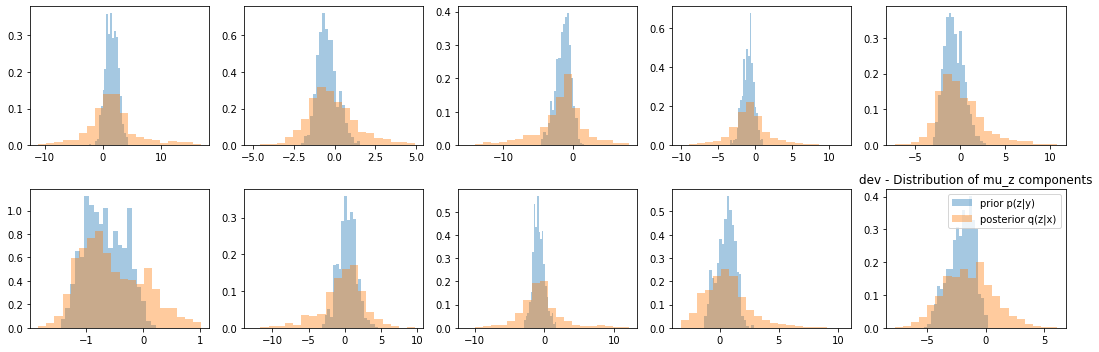

In [14]:
plot_components_hist(mu_p, mu_q, f"{dataset} - Distribution of mu_z components")

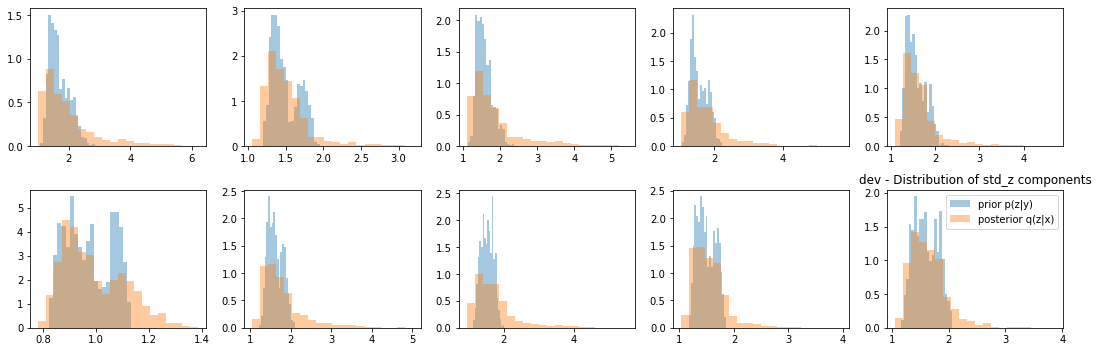

In [15]:
plot_components_hist(std_p, std_q, f"{dataset} - Distribution of std_z components")

In [16]:
dataset = "train_g2t"
mu_p, std_p, mu_q, std_q, graph_list, text_list = compute_latent_vectors(dataset)

100%|██████████| 385/385 [00:23<00:00, 16.13it/s]

(12316, 10)


In [17]:
writer.add_embedding(mu_p, graph_list, tag=f"mu_p {dataset} - p(z|y)")
writer.add_embedding(std_p, graph_list, tag=f"std_p {dataset} - p(z|y)")
writer.add_embedding(mu_q, text_list, tag=f"mu_q {dataset} - q(z|x)")
writer.add_embedding(std_q, text_list, tag=f"std_q {dataset} - q(z|x)")

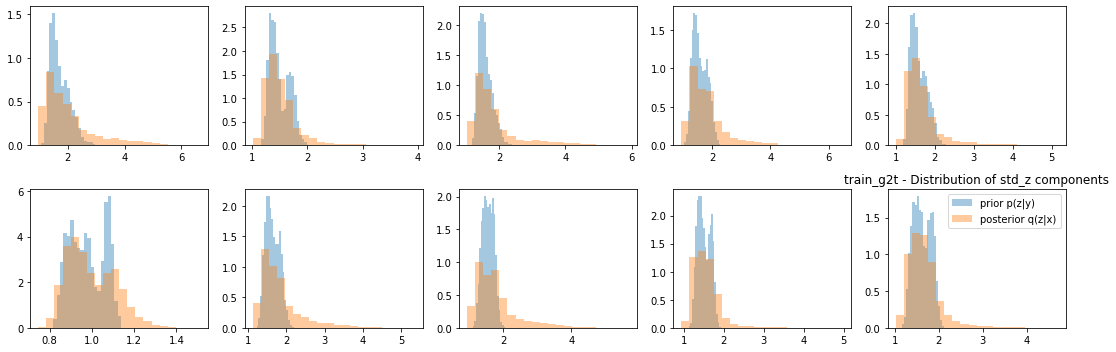

In [18]:
plot_components_hist(std_p, std_q, f"{dataset} - Distribution of std_z components")